In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.standard_generator import StandardDataGenerator
from environments.contextual_environment import ContextualEnvironment
from learners.pricing.contextual_learner import ContextualLearner
from learners.pricing.thompson_sampling import ThompsonSampling
from learners.pricing.ucb import UCB
from utils.context_generator_v2 import ContextGenerator 

In [2]:
src = 'src/basic005.json'

In [3]:
dg = StandardDataGenerator(filename=src)

In [4]:
selected_bid = 3
T = 365
n_experiments = 1
learners_to_test = [ThompsonSampling]
cg_start_from = 50
cg_confidence = 0.01
cg_frequency = 10

features = dg.get_features() 
fractions = dg.get_class_distributions(selected_bid)
bandit_args = {
            'arm_values': dg.get_margins()
}
env_args = {
    'bid_idx': selected_bid,
    'mode': 'all',
    'src': dg.get_source(),
    'generator': 'standard'
}

In [5]:
rewards_per_experiment = {}
context_split_per_experiment = {}
days_of_split = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []
    context_split_per_experiment[learner.LEARNER_NAME] = []
    days_of_split[learner.LEARNER_NAME] = []

In [6]:
leaves_feature = {}
leaves_feature[True,True] = "C1"
leaves_feature[True,False] = "C3"
leaves_feature[False,True] = "C3"
leaves_feature[False,False] = "C2"
print(leaves_feature)



int_classes = {}
int_classes["C1"] = 0
int_classes["C2"] = 1
int_classes["C3"] = 2

int_to_feature_1 = {}
int_to_feature_1[0] = True
int_to_feature_1[1] = True
int_to_feature_1[2] = False
int_to_feature_1[3] = False

int_to_feature_2 = {}
int_to_feature_2[0] = True
int_to_feature_2[1] = False
int_to_feature_2[2] = True
int_to_feature_2[3] = False

splitted_rewards_per_experiment = {}
splitted_rewards_per_experiment[True,True] = []
splitted_rewards_per_experiment[True,False] = []
splitted_rewards_per_experiment[False,True] = []
splitted_rewards_per_experiment[False,False] = []

opt_per_experiment = {}
opt_per_experiment[True,True] = []
opt_per_experiment[True,False] = []
opt_per_experiment[False,True] = []
opt_per_experiment[False,False] = []

{(True, True): 'C1', (True, False): 'C3', (False, True): 'C3', (False, False): 'C2'}


In [7]:
margins = dg.get_margins()
classes = dg.get_classes()
conversion_rates = dg.get_conversion_rates(mode='all')
future_purchases = dg.get_future_purchases(mode='all')
selected_bid = 3
number_of_clicks = dg.get_daily_clicks(mode='all')
costs_per_click = dg.get_costs_per_click(mode='aggregate', bid=selected_bid)
fixed_cost = costs_per_click[selected_bid]
fixed_n_clicks = np.rint(dg.get_daily_clicks(mode='aggregate')[selected_bid]).astype(int)
fractions = dg.get_class_distributions(selected_bid)

temp = (margins * np.average(conversion_rates * (1 + future_purchases),
                             axis=0,
                             weights=fractions) - fixed_cost) * fixed_n_clicks
aggr_opt_arm = np.argmax(temp)
aggr_opt = np.max(temp)

disaggr_opt = 0
opt_arms = []
opt_values = []
for i, _ in enumerate(conversion_rates):
    t = (margins * conversion_rates[i] * (1 + future_purchases[i]) - fixed_cost) * \
                number_of_clicks[i, selected_bid]
    opt_arm = np.argmax(t)
    opt_value = np.max(t)
    opt_arms.append(opt_arm)
    opt_values.append(opt_value)
    disaggr_opt += opt_value

In [8]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'\n\nrunning experiment {e + 1}/{n_experiments}...')
    test_instances = []
    
    for learner in learners_to_test:
        context_learner = ContextualLearner(features, learner, **bandit_args)
        test_instances.append(
            (context_learner,
             ContextualEnvironment(**env_args),
             ContextGenerator(features=features,
                              contextual_learner=context_learner,
                              update_frequency=cg_frequency,
                              start_from=cg_start_from,
                              confidence=cg_confidence,
                              verbose=0))
        )
    for t in range(T):
        for context_learner, env, context_generator in test_instances:
            print(f'##### DAY {t} ######')
            context_learner.next_day()
            past_arms = None
            past_features = None
            month_purchases = env.get_next_purchases_at_day(t, keep=False)
            if month_purchases is not None:
                past_arms = env.get_selected_arms_at_day(t - 30, keep=False)
                past_features = env.get_collected_user_features_at_day(t - 30, keep=False)
                context_learner.update_next_purchases(past_arms, month_purchases, past_features)

            pulled_arms = context_learner.pull_arms()
            daily_rewards = env.day_round(pulled_arms)
            daily_users_features = env.get_collected_user_features_at_day(t)
            daily_pulled_arms = env.get_selected_arms_at_day(t)

            context_learner.update(daily_rewards, daily_pulled_arms, daily_users_features)
            context_generator.collect_daily_data(daily_pulled_arms, daily_rewards, daily_users_features,
                                                         next_purchases=month_purchases, past_pulled_arms=past_arms,
                                                         past_features=past_features)
    for learner, _, _ in test_instances:
        learner.next_day()
        rewards_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_daily_rewards())
        context_split_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_splits_count())
        days_of_split[learner.base_learner_class.LEARNER_NAME].append(context_generator.metadata['SPLIT_DAYS'])
    # end -> save rhe results.
        if learner.base_learner_class.LEARNER_NAME == 'TS-Pricing':
        #split_day=learner.context_tree.collected_splits[0]+16#should be a list, returns only one value??
            for leaf in learner.context_tree.get_leaves():
                print(f"feature subspace: {leaf.feature_subspace}")
                feature_2=leaf.feature_subspace['feature-2']
                feature_1=leaf.feature_subspace['feature-1']
                leaf_class=leaves_feature[feature_1,feature_2]
                leaf_values=leaf.get_daily_rewards()
                
                print(f"leaf class: {leaf_class} ")
                print(f"leaf values: {leaf_values}")
                print(len(leaf_values))
                split_day=T-len(leaf_values)
                print(split_day)
                splitted_rewards_per_experiment[feature_1,feature_2].append(leaf_values) #save rewards for specific leaf
                opt_single = opt_values[int_classes[leaf_class]] #calculate opt for specific leaf 
                opt=[]
                for relative_day,val in enumerate(leaf_values): #
                    curr_day=split_day+relative_day
                    custom_clicks=env.collected_users_categories[curr_day,leaf_class] #call function on the env that returns n of clicks for current day
                    optimal_value= opt_single #* custom_clicks
                    opt.append(optimal_value)
                opt_per_experiment[feature_1,feature_2].append(opt) #save list of optimal values for the current leaf specified by her features





running experiment 1/1...
##### DAY 0 ######
##### DAY 1 ######
##### DAY 2 ######
##### DAY 3 ######
##### DAY 4 ######
##### DAY 5 ######
##### DAY 6 ######
##### DAY 7 ######
##### DAY 8 ######
##### DAY 9 ######
##### DAY 10 ######
##### DAY 11 ######
##### DAY 12 ######
##### DAY 13 ######
##### DAY 14 ######
##### DAY 15 ######
##### DAY 16 ######
##### DAY 17 ######
##### DAY 18 ######
##### DAY 19 ######
##### DAY 20 ######
##### DAY 21 ######
##### DAY 22 ######
##### DAY 23 ######
##### DAY 24 ######
##### DAY 25 ######
##### DAY 26 ######
##### DAY 27 ######
##### DAY 28 ######
##### DAY 29 ######
##### DAY 30 ######
##### DAY 31 ######
##### DAY 32 ######
##### DAY 33 ######
##### DAY 34 ######
##### DAY 35 ######
##### DAY 36 ######
##### DAY 37 ######
##### DAY 38 ######
##### DAY 39 ######
##### DAY 40 ######
##### DAY 41 ######
##### DAY 42 ######
##### DAY 43 ######
##### DAY 44 ######
##### DAY 45 ######
##### DAY 46 ######
##### DAY 47 ######
##### DAY 48 ######
##

#345: [(False, False)] -> {'feature-1': False}
#346: [(True, False)] -> {'feature-1': True}
#347: [(False, False)] -> {'feature-1': False}
#348: [(True, True)] -> {'feature-1': True}
#349: [(False, True)] -> {'feature-1': False}
#350: [(False, False)] -> {'feature-1': False}
#351: [(True, False)] -> {'feature-1': True}
#352: [(True, True)] -> {'feature-1': True}
#353: [(False, False)] -> {'feature-1': False}
#354: [(True, False)] -> {'feature-1': True}
#355: [(True, True)] -> {'feature-1': True}
#356: [(True, True)] -> {'feature-1': True}
#357: [(False, True)] -> {'feature-1': False}
#358: [(False, False)] -> {'feature-1': False}
#359: [(True, True)] -> {'feature-1': True}
#360: [(False, False)] -> {'feature-1': False}
#361: [(True, True)] -> {'feature-1': True}
#362: [(True, False)] -> {'feature-1': True}
#363: [(False, False)] -> {'feature-1': False}
#364: [(True, False)] -> {'feature-1': True}
#365: [(False, False)] -> {'feature-1': False}
#366: [(True, False)] -> {'feature-1': True

#0: [(False, False)] -> {'feature-1': False}
#1: [(False, False)] -> {'feature-1': False}
#2: [(True, False)] -> {'feature-1': True}
#3: [(True, True)] -> {'feature-1': True}
#4: [(True, True)] -> {'feature-1': True}
#5: [(False, True)] -> {'feature-1': False}
#6: [(False, False)] -> {'feature-1': False}
#7: [(True, True)] -> {'feature-1': True}
#8: [(True, True)] -> {'feature-1': True}
#9: [(True, True)] -> {'feature-1': True}
#10: [(False, False)] -> {'feature-1': False}
#11: [(True, True)] -> {'feature-1': True}
#12: [(False, False)] -> {'feature-1': False}
#13: [(True, True)] -> {'feature-1': True}
#14: [(True, True)] -> {'feature-1': True}
#15: [(True, True)] -> {'feature-1': True}
#16: [(True, True)] -> {'feature-1': True}
#17: [(False, False)] -> {'feature-1': False}
#18: [(True, True)] -> {'feature-1': True}
#19: [(True, False)] -> {'feature-1': True}
#20: [(True, True)] -> {'feature-1': True}
#21: [(True, True)] -> {'feature-1': True}
#22: [(False, False)] -> {'feature-1': Fal

#265: [(True, False)] -> {'feature-1': True}
#266: [(False, False)] -> {'feature-1': False}
#267: [(True, False)] -> {'feature-1': True}
#268: [(True, True)] -> {'feature-1': True}
#269: [(True, True)] -> {'feature-1': True}
#270: [(False, False)] -> {'feature-1': False}
#271: [(True, True)] -> {'feature-1': True}
#272: [(False, True)] -> {'feature-1': False}
#273: [(True, False)] -> {'feature-1': True}
#274: [(False, False)] -> {'feature-1': False}
#275: [(True, True)] -> {'feature-1': True}
#276: [(True, False)] -> {'feature-1': True}
#277: [(True, False)] -> {'feature-1': True}
#278: [(True, True)] -> {'feature-1': True}
#279: [(True, True)] -> {'feature-1': True}
#280: [(True, False)] -> {'feature-1': True}
#281: [(True, True)] -> {'feature-1': True}
#282: [(False, False)] -> {'feature-1': False}
#283: [(False, False)] -> {'feature-1': False}
#284: [(True, True)] -> {'feature-1': True}
#285: [(False, False)] -> {'feature-1': False}
#286: [(True, False)] -> {'feature-1': True}
#287:

#7: [(True, True)] -> {'feature-1': True}
#8: [(True, True)] -> {'feature-1': True}
#9: [(True, True)] -> {'feature-1': True}
#10: [(False, True)] -> {'feature-1': False}
#11: [(False, False)] -> {'feature-1': False}
#12: [(False, False)] -> {'feature-1': False}
#13: [(True, True)] -> {'feature-1': True}
#14: [(True, True)] -> {'feature-1': True}
#15: [(True, True)] -> {'feature-1': True}
#16: [(True, True)] -> {'feature-1': True}
#17: [(True, True)] -> {'feature-1': True}
#18: [(True, False)] -> {'feature-1': True}
#19: [(True, False)] -> {'feature-1': True}
#20: [(False, True)] -> {'feature-1': False}
#21: [(True, False)] -> {'feature-1': True}
#22: [(True, True)] -> {'feature-1': True}
#23: [(False, False)] -> {'feature-1': False}
#24: [(False, True)] -> {'feature-1': False}
#25: [(True, True)] -> {'feature-1': True}
#26: [(False, False)] -> {'feature-1': False}
#27: [(True, True)] -> {'feature-1': True}
#28: [(False, False)] -> {'feature-1': False}
#29: [(False, True)] -> {'feature

#382: [(False, False)] -> {'feature-1': False}
#383: [(True, True)] -> {'feature-1': True}
#384: [(False, False)] -> {'feature-1': False}
#385: [(True, False)] -> {'feature-1': True}
#386: [(False, True)] -> {'feature-1': False}
#387: [(True, True)] -> {'feature-1': True}
#388: [(True, True)] -> {'feature-1': True}
#389: [(True, True)] -> {'feature-1': True}
#390: [(True, True)] -> {'feature-1': True}
#391: [(True, False)] -> {'feature-1': True}
#392: [(True, True)] -> {'feature-1': True}
#393: [(True, True)] -> {'feature-1': True}
#394: [(False, True)] -> {'feature-1': False}
#395: [(True, True)] -> {'feature-1': True}
#396: [(False, False)] -> {'feature-1': False}
#397: [(False, True)] -> {'feature-1': False}
#398: [(True, False)] -> {'feature-1': True}
#399: [(True, False)] -> {'feature-1': True}
#400: [(True, True)] -> {'feature-1': True}
#401: [(False, False)] -> {'feature-1': False}
#402: [(False, False)] -> {'feature-1': False}
#403: [(True, True)] -> {'feature-1': True}
#404: [

#0: [(True, True)] -> {'feature-1': True}
#1: [(False, False)] -> {'feature-1': False}
#2: [(True, True)] -> {'feature-1': True}
#3: [(False, False)] -> {'feature-1': False}
#4: [(True, True)] -> {'feature-1': True}
#5: [(False, False)] -> {'feature-1': False}
#6: [(True, True)] -> {'feature-1': True}
#7: [(True, True)] -> {'feature-1': True}
#8: [(False, False)] -> {'feature-1': False}
#9: [(True, True)] -> {'feature-1': True}
#10: [(False, True)] -> {'feature-1': False}
#11: [(True, True)] -> {'feature-1': True}
#12: [(False, False)] -> {'feature-1': False}
#13: [(True, True)] -> {'feature-1': True}
#14: [(False, False)] -> {'feature-1': False}
#15: [(True, False)] -> {'feature-1': True}
#16: [(True, True)] -> {'feature-1': True}
#17: [(False, False)] -> {'feature-1': False}
#18: [(True, True)] -> {'feature-1': True}
#19: [(True, True)] -> {'feature-1': True}
#20: [(True, True)] -> {'feature-1': True}
#21: [(True, True)] -> {'feature-1': True}
#22: [(True, False)] -> {'feature-1': Tr

##### DAY 131 ######
#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(False, True)] -> {'featu

#119: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#120: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#121: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#122: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#123: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#124: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#125: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#126: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#127: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#128: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#129: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#130: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#131: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#132: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#133: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#134: [(True, True)] -> {'feature-1': T

#53: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#54: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#55: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#56: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#57: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#58: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#59: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#60: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#61: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#62: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#63: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#64: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#65: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#66: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#67: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#68: [(False, True)] -> {'feature-1': False,

#120: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#121: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#122: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#123: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#124: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#125: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#126: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#127: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#128: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#129: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#130: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#131: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#132: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#133: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#134: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#135: [(True, True)] -> {'feature-1': Tru

#400: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#401: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#402: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#403: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#404: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#405: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#406: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#407: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#408: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#409: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#410: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#411: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#412: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#413: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#414: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#415: [(False, False)] -> {'featu

#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#11: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#12: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#16: [(True, True)] -> {'feature-1': True, 'featu

#270: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#271: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#272: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#273: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#274: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#275: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#276: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#277: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#278: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#279: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#280: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#281: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#282: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#283: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#284: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#285: [(True, True)] -> {'fea

#104: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#105: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#106: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#107: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#108: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#109: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#110: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#111: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#112: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#113: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#114: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#115: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#116: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#117: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#118: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#119: [(False, False)] -> {

#267: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#268: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#269: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#270: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#271: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#272: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#273: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#274: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#275: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#276: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#277: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#278: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#279: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#280: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#281: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#282: [(True, True)] -> {'fea

#426: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#427: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#428: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#429: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#430: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#431: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#432: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#433: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#434: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#435: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#436: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#437: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#438: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#439: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#440: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#441: [(True, True)] -> {

#67: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#68: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#69: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#70: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#71: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#72: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#73: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#74: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#75: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#76: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#77: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#78: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#79: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#80: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#81: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#82: [(False, False)] -> {'feature-1': False, 'feature-2

#266: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#267: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#268: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#269: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#270: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#271: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#272: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#273: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#274: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#275: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#276: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#277: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#278: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#279: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#280: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#281: [(False, True)] -

#435: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#436: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#437: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#438: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#439: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#440: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#441: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#442: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#443: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#444: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#445: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#446: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#447: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#448: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#449: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#450: [(True, True)] -> {'f

#211: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#212: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#213: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#214: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#215: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#216: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#217: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#218: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#219: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#220: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#221: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#222: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#223: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#224: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#225: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#226: [(True, True)] -> {

#0: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#8: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#9: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#13: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(True, True)] -> {'feature-1': Tru

#278: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#279: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#280: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#281: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#282: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#283: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#284: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#285: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#286: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#287: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#288: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#289: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#290: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#291: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#292: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#293: [(False, Fa

#372: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#373: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#374: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#375: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#376: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#377: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#378: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#379: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#380: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#381: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#382: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#383: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#384: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#385: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#386: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#387: [(False, Fa

#158: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#159: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#160: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#161: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#162: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#163: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#164: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#165: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#166: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#167: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#168: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#169: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#170: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#171: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#172: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#173: [(True, False)] -> {'

#238: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#239: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#240: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#241: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#242: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#243: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#244: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#245: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#246: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#247: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#248: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#249: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#250: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#251: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#252: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#253: [(False, False)] ->

#264: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#265: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#266: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#267: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#268: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#269: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#270: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#271: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#272: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#273: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#274: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#275: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#276: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#277: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#278: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#279: [(True, True)] -> {'feature-1': True, '

#7: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#8: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#13: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#16: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#17: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#18: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#19: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#20: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#21: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#22: [(False, False)] -> {'feature-1': Fa

#348: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#349: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#350: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#351: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#352: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#353: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#354: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#355: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#356: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#357: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#358: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#359: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#360: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#361: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#362: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#363: [(True, True)] -> {'feature

#401: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#402: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#403: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#404: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#405: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#406: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#407: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#408: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#409: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#410: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#411: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#412: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#413: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#414: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#415: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#416: [(True, True)] ->

##### DAY 162 ######
#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#8: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(False, False)] -> {'fe

#69: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#70: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#71: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#72: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#73: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#74: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#75: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#76: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#77: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#78: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#79: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#80: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#81: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#82: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#83: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#84: [(False, False)] -> {'feature-1': False, 

#276: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#277: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#278: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#279: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#280: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#281: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#282: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#283: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#284: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#285: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#286: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#287: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#288: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#289: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#290: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#291: [(False, True)]

#360: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#361: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#362: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#363: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#364: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#365: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#366: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#367: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#368: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#369: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#370: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#371: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#372: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#373: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#374: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#375: [(True, False)]

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#11: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True, 'feature-2': 

#79: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#80: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#81: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#82: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#83: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#84: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#85: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#86: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#87: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#88: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#89: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#90: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#91: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#92: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#93: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#94: [(True, False)] -> {'feature-1': True, 'fea

#399: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#400: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#401: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#402: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#403: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#404: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#405: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#406: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#407: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#408: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#409: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#410: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#411: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#412: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#413: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#414: [(True, True)] -> {'feature-1':

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True, 'feature-

#247: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#248: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#249: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#250: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#251: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#252: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#253: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#254: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#255: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#256: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#257: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#258: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#259: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#260: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#261: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#262: [(False, True)] -> {'feature-1': Fals

#377: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#378: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#379: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#380: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#381: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#382: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#383: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#384: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#385: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#386: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#387: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#388: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#389: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#390: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#391: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#392: [(False, True)] -> {'feature-

#311: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#312: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#313: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#314: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#315: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#316: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#317: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#318: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#319: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#320: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#321: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#322: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#323: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#324: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#325: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#326: [(False, True)] -> {'featur

#303: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#304: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#305: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#306: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#307: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#308: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#309: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#310: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#311: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#312: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#313: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#314: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#315: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#316: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#317: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#318: [(False, False)] -> {'fea

#328: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#329: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#330: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#331: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#332: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#333: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#334: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#335: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#336: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#337: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#338: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#339: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#340: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#341: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#342: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#343: [(True, True)] -> {'feature

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#2: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#3: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(False, False)] -> {'feature-1': False, 'feature-2': Fal

#153: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#154: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#155: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#156: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#157: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#158: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#159: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#160: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#161: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#162: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#163: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#164: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#165: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#166: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#167: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#168: [(False, True)] -> {'

#348: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#349: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#350: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#351: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#352: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#353: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#354: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#355: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#356: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#357: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#358: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#359: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#360: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#361: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#362: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#363: [(False, False)

#0: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#1: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#2: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(True, True)] -> {'feature-1': True, 'feature-2': Tr

#110: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#111: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#112: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#113: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#114: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#115: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#116: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#117: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#118: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#119: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#120: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#121: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#122: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#123: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#124: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#125: [(True, True)] -> {'feature-1

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#14: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#15: [(False, True)] -> {'feature-1': False, 'feature-2': 

#50: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#51: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#52: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#53: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#54: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#55: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#56: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#57: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#58: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#59: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#60: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#61: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#62: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#63: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#64: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#65: [(False, False)] -> {'feature-1': F

#202: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#203: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#204: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#205: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#206: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#207: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#208: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#209: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#210: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#211: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#212: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#213: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#214: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#215: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#216: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#217: [(True, False)] -> {'feature-1': 

#238: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#239: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#240: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#241: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#242: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#243: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#244: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#245: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#246: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#247: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#248: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#249: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#250: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#251: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#252: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#253: [(False, False)] -> {'feature

#342: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#343: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#344: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#345: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#346: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#347: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#348: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#349: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#350: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#351: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#352: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#353: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#354: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#355: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#356: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#357: [(False, True)]

#45: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#46: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#47: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#48: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#49: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#50: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#51: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#52: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#53: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#54: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#55: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#56: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#57: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#58: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#59: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#60: [(True, True)] -> {'feature-1': True, 'fe

#238: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#239: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#240: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#241: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#242: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#243: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#244: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#245: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#246: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#247: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#248: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#249: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#250: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#251: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#252: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#253: [(True, True)] -> {'fea

#344: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#345: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#346: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#347: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#348: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#349: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#350: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#351: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#352: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#353: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#354: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#355: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#356: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#357: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#358: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#359: [(True, True)] -> {'featu

#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#7: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True, 'feature-

#237: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#238: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#239: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#240: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#241: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#242: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#243: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#244: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#245: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#246: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#247: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#248: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#249: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#250: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#251: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#252: [(False, True)]

##### DAY 198 ######
#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#3: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True

#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True, 'featur

#102: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#103: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#104: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#105: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#106: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#107: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#108: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#109: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#110: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#111: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#112: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#113: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#114: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#115: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#116: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#117: [(True, True)] -> {'featu

#326: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#327: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#328: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#329: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#330: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#331: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#332: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#333: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#334: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#335: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#336: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#337: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#338: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#339: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#340: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#341: [(True, True)] -> {'feature-1':

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#3: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#4: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#5: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#14: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#15: [(False, False)] -> {'feature-1': False, 'featu

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(False, False)] -> {'feature-1': False, 'featu

#157: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#158: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#159: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#160: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#161: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#162: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#163: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#164: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#165: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#166: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#167: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#168: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#169: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#170: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#171: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#172: [(True, True)] -> {'fea

#368: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#369: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#370: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#371: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#372: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#373: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#374: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#375: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#376: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#377: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#378: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#379: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#380: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#381: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#382: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#383: [(False, False)] -> {'feature

#380: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#381: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#382: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#383: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#384: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#385: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#386: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#387: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#388: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#389: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#390: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#391: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#392: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#393: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#394: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#395: [(True, True)] -> {'feature

#58: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#59: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#60: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#61: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#62: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#63: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#64: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#65: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#66: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#67: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#68: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#69: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#70: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#71: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#72: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#73: [(True, True)] -> {'feature-1': True, 'feature-2'

#210: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#211: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#212: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#213: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#214: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#215: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#216: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#217: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#218: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#219: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#220: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#221: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#222: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#223: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#224: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#225: [(False, True)] -> 

#239: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#240: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#241: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#242: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#243: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#244: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#245: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#246: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#247: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#248: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#249: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#250: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#251: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#252: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#253: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#254: [(False, True)] -> 

#238: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#239: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#240: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#241: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#242: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#243: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#244: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#245: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#246: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#247: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#248: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#249: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#250: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#251: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#252: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#253: [(False, False)] -> {'feature-1':

#391: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#392: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#393: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#394: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#395: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#396: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#397: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#398: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#399: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#400: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#401: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#402: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#403: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#404: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#405: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#406: [(True, True)] -> {'feature-1

#359: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#360: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#361: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#362: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#363: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#364: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#365: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#366: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#367: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#368: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#369: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#370: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#371: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#372: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#373: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#374: [(True, False)] -> {'feat

#0: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#16:

#0: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#15: [(True, False)] -> {'feature-1': True, 'feature

#151: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#152: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#153: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#154: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#155: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#156: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#157: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#158: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#159: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#160: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#161: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#162: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#163: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#164: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#165: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#166: [(True, False)] -

#76: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#77: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#78: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#79: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#80: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#81: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#82: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#83: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#84: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#85: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#86: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#87: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#88: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#89: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#90: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#91: [(False, True)] -> {'feature-1': False, 'feat

#191: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#192: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#193: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#194: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#195: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#196: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#197: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#198: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#199: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#200: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#201: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#202: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#203: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#204: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#205: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#206: [(False, 

#242: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#243: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#244: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#245: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#246: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#247: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#248: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#249: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#250: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#251: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#252: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#253: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#254: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#255: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#256: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#257: [(True, True)] -> {'feature-1': True, '

#333: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#334: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#335: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#336: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#337: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#338: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#339: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#340: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#341: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#342: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#343: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#344: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#345: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#346: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#347: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#348: [(True, True)] -> {'feature

#391: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#392: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#393: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#394: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#395: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#396: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#397: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#398: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#399: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#400: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#401: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#402: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#403: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#404: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#405: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#406: [(False, False)] 

#128: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#129: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#130: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#131: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#132: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#133: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#134: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#135: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#136: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#137: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#138: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#139: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#140: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#141: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#142: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#143: [(True, True)] -> {'feature-1':

#315: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#316: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#317: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#318: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#319: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#320: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#321: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#322: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#323: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#324: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#325: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#326: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#327: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#328: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#329: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#330: [(False, True)] -

#31: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#32: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#33: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#34: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#35: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#36: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#37: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#38: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#39: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#40: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#41: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#42: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#43: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#44: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#45: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#46: [(True, True)] -> {'feature-1': True, 'feat

#258: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#259: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#260: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#261: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#262: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#263: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#264: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#265: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#266: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#267: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#268: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#269: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#270: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#271: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#272: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#273: [(True, True)] -> {'featu

#53: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#54: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#55: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#56: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#57: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#58: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#59: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#60: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#61: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#62: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#63: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#64: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#65: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#66: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#67: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#68: [(True, True)] -> {'feature-1': True, 'featur

#182: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#183: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#184: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#185: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#186: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#187: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#188: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#189: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#190: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#191: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#192: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#193: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#194: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#195: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#196: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#197: [(False, False)] -> {

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#10: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(False, True)] -> {'feature-1': False, 'feature-

#166: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#167: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#168: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#169: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#170: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#171: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#172: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#173: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#174: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#175: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#176: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#177: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#178: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#179: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#180: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#181: [(True, True)] -> {'fea

#0: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#1: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#2: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True, 'feature-2': 

#232: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#233: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#234: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#235: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#236: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#237: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#238: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#239: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#240: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#241: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#242: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#243: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#244: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#245: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#246: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#247: [(False, False)] -> {'fea

#423: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#424: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#425: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#426: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#427: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#428: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#429: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#430: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#431: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#432: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#433: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#434: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#435: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#436: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#437: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#438: [(True, True)] -> {'featu

#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#4: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#5: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#16: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#17: [(True, False)] -> {'feature-1': True, 'feature-2

#264: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#265: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#266: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#267: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#268: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#269: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#270: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#271: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#272: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#273: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#274: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#275: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#276: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#277: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#278: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#279: [(True, True)] -> {

#335: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#336: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#337: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#338: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#339: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#340: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#341: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#342: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#343: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#344: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#345: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#346: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#347: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#348: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#349: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#350: [(True, True)] -> {'fea

##### DAY 245 ######
#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#7: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(True, True)] -> {'feature-1'

#252: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#253: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#254: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#255: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#256: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#257: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#258: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#259: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#260: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#261: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#262: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#263: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#264: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#265: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#266: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#267: [(True, False)] -> 

#0: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(True, True)] -> {'feature-1': True, 'feat

#299: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#300: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#301: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#302: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#303: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#304: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#305: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#306: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#307: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#308: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#309: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#310: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#311: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#312: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#313: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#314: [(False, False)] -> {'feature-1

#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#5: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(False, True)] -> {'feature-1': False, 'feature-2': True

#159: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#160: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#161: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#162: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#163: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#164: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#165: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#166: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#167: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#168: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#169: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#170: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#171: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#172: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#173: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#174: [(False, False)] -> {'f

#354: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#355: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#356: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#357: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#358: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#359: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#360: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#361: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#362: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#363: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#364: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#365: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#366: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#367: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#368: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#369: [(True, Tru

#57: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#58: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#59: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#60: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#61: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#62: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#63: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#64: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#65: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#66: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#67: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#68: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#69: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#70: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#71: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#72: [(True, True)] -> {'feature-1': Tru

#238: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#239: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#240: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#241: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#242: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#243: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#244: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#245: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#246: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#247: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#248: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#249: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#250: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#251: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#252: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#253: [(True, True)

#409: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#410: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#411: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#412: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#413: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#414: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#415: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#416: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#417: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#418: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#419: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#420: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#421: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#422: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#423: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#424: [(True, True)] -> {'feature-1

#72: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#73: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#74: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#75: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#76: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#77: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#78: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#79: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#80: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#81: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#82: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#83: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#84: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#85: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#86: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#87: [(False, False)] -> {'feature-1':

#37: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#38: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#39: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#40: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#41: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#42: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#43: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#44: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#45: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#46: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#47: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#48: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#49: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#50: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#51: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#52: [(True, True)] -> {'feature-1':

#93: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#94: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#95: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#96: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#97: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#98: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#99: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#100: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#101: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#102: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#103: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#104: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#105: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#106: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#107: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#108: [(True, True)] -> {'feature-1'

#191: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#192: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#193: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#194: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#195: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#196: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#197: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#198: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#199: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#200: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#201: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#202: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#203: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#204: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#205: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#206: [(True, True)] -> {'fea

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#10: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True, 'feature-2': 

#194: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#195: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#196: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#197: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#198: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#199: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#200: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#201: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#202: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#203: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#204: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#205: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#206: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#207: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#208: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#209: [(True, True)] -> {'fea

#423: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#424: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#425: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#426: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#427: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#428: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#429: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#430: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#431: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#432: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#433: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#434: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#435: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#436: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#437: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#438: [(False, True)] -> {'featur

#0: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#8: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(True, False)] -> {'feature-1': True, 'featu

#398: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#399: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#400: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#401: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#402: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#403: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#404: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#405: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#406: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#407: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#408: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#409: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#410: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#411: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#412: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#413: [(False, True)] -> 

#412: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#413: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#414: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#415: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#416: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#417: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#418: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#419: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#420: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#421: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#422: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#423: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#424: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#425: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#426: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#427: [(True, True)] -> {'feature-1': Tru

#37: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#38: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#39: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#40: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#41: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#42: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#43: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#44: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#45: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#46: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#47: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#48: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#49: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#50: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#51: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#52: [(False, False)] -> {'feature-1': False, 'f

#242: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#243: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#244: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#245: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#246: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#247: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#248: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#249: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#250: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#251: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#252: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#253: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#254: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#255: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#256: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#257: [(True, False)] -> {'

#244: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#245: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#246: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#247: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#248: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#249: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#250: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#251: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#252: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#253: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#254: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#255: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#256: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#257: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#258: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#259: [(True, True)] -> {'fea

#391: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#392: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#393: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#394: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#395: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#396: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#397: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#398: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#399: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#400: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#401: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#402: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#403: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#404: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#405: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#406: [(True, True)] -> {'fea

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#15: [(True, False)] -> {'feature-1': True, 'feature-2': False

#279: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#280: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#281: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#282: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#283: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#284: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#285: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#286: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#287: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#288: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#289: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#290: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#291: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#292: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#293: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#294: [(False, True)] -> {'featur

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#4: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#14: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#15: [(True, False)] -> {'feature-1': True, 'featu

#37: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#38: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#39: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#40: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#41: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#42: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#43: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#44: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#45: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#46: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#47: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#48: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#49: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#50: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#51: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#52: [(True, True)] -> {'feature-1':

#310: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#311: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#312: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#313: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#314: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#315: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#316: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#317: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#318: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#319: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#320: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#321: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#322: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#323: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#324: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#325: [(True, True)] -> {'fea

#346: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#347: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#348: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#349: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#350: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#351: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#352: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#353: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#354: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#355: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#356: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#357: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#358: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#359: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#360: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#361: [(True, True)] -> {'f

#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#12: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#13: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#14: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#15: [(True, True)] -> {'feature-1': True, 'feature-2': True

##### DAY 287 ######
#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(False, False)] -> {'feature-1': False,

#88: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#89: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#90: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#91: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#92: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#93: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#94: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#95: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#96: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#97: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#98: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#99: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#100: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#101: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#102: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#103: [(True, True)] -> {'feature-1': True, '

#270: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#271: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#272: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#273: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#274: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#275: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#276: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#277: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#278: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#279: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#280: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#281: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#282: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#283: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#284: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#285: [(True, True)] -> {

##### DAY 291 ######
#0: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#7: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#8: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(False, False)] -> {'feature-1': Fals

#43: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#44: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#45: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#46: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#47: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#48: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#49: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#50: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#51: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#52: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#53: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#54: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#55: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#56: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#57: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#58: [(True, True)] -> {'feature-1':

#423: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#424: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#425: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#426: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#427: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#428: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#429: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#430: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#431: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#432: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#433: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#434: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#435: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#436: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#437: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#438: [(False, True)] -> {'feat

#19: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#20: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#21: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#22: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#23: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#24: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#25: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#26: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#27: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#28: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#29: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#30: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#31: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#32: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#33: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#34: [(True, True)] -> {'feature-1': True, 'feature-2': 

#1: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#16: [(False, True)] -> {'feature-1': False, 'feature-2':

#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(False, False)] -> {'feature-1': False

#248: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#249: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#250: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#251: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#252: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#253: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#254: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#255: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#256: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#257: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#258: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#259: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#260: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#261: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#262: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#263: [(True, True)] 

##### DAY 300 ######
#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#9: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(False, True)] -> {'feature-1': F

#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True, 'feature-2': 

#149: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#150: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#151: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#152: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#153: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#154: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#155: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#156: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#157: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#158: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#159: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#160: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#161: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#162: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#163: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#164: [(False, True)]

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#15: [(True, False)] -> {'feature-1': True, 'feature-2':

#64: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#65: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#66: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#67: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#68: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#69: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#70: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#71: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#72: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#73: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#74: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#75: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#76: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#77: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#78: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#79: [(True, False)] -> {'feature-1': True, 'feature-2': False}


#361: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#362: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#363: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#364: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#365: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#366: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#367: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#368: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#369: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#370: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#371: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#372: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#373: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#374: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#375: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#376: [(True, True)] ->

#395: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#396: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#397: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#398: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#399: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#400: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#401: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#402: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#403: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#404: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#405: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#406: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#407: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#408: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#409: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#410: [(False, True)] -> {'featur

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#6: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#7: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(False, False)] -> {'feature-1': False, 'feature

#15: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#16: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#17: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#18: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#19: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#20: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#21: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#22: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#23: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#24: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#25: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#26: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#27: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#28: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#29: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#30: [(True, False)] -> {'feature-1': True, 'f

#246: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#247: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#248: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#249: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#250: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#251: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#252: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#253: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#254: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#255: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#256: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#257: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#258: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#259: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#260: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#261: [(False, False)] -> {'feature-1':

#200: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#201: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#202: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#203: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#204: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#205: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#206: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#207: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#208: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#209: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#210: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#211: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#212: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#213: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#214: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#215: [(True, True)] -> {'feature

#278: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#279: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#280: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#281: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#282: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#283: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#284: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#285: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#286: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#287: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#288: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#289: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#290: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#291: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#292: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#293: [(True, True)] -> {'feature

#305: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#306: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#307: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#308: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#309: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#310: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#311: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#312: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#313: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#314: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#315: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#316: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#317: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#318: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#319: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#320: [(True, True)] -> {'feature-1

#144: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#145: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#146: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#147: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#148: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#149: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#150: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#151: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#152: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#153: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#154: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#155: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#156: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#157: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#158: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#159: [(True,

#380: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#381: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#382: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#383: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#384: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#385: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#386: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#387: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#388: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#389: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#390: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#391: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#392: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#393: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#394: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#395: [(True, False)] -

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#4: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True, 'feature-2': 

#209: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#210: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#211: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#212: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#213: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#214: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#215: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#216: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#217: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#218: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#219: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#220: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#221: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#222: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#223: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#224: [(False, False)] -> {'feature-1

##### DAY 322 ######
#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#15: [(True, True)] -> {'fe

#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#16: [(False, False)] -> {'feature-1': False, 'fe

#369: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#370: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#371: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#372: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#373: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#374: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#375: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#376: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#377: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#378: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#379: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#380: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#381: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#382: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#383: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#384: [(True, True)] 

##### DAY 326 ######
#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#7: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#8: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, True)] -> {'fe

#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#5: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#16: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#17: [(True, True)] -> {'feature-1': True, 'feature-2'

#42: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#43: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#44: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#45: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#46: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#47: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#48: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#49: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#50: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#51: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#52: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#53: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#54: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#55: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#56: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#57: [(True, False)] -> {'feature-1': True, 

#226: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#227: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#228: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#229: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#230: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#231: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#232: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#233: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#234: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#235: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#236: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#237: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#238: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#239: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#240: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#241: [(True, False)] -> {'feature-

#224: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#225: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#226: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#227: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#228: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#229: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#230: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#231: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#232: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#233: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#234: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#235: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#236: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#237: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#238: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#239: [(False, False)

##### DAY 332 ######
#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, True)] -> {'feature-

#0: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True, 'feature-2': True

#281: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#282: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#283: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#284: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#285: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#286: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#287: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#288: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#289: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#290: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#291: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#292: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#293: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#294: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#295: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#296: [(True, True)] -> {'featu

#331: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#332: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#333: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#334: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#335: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#336: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#337: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#338: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#339: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#340: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#341: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#342: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#343: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#344: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#345: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#346: [(False, True)] -> {'

#47: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#48: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#49: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#50: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#51: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#52: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#53: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#54: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#55: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#56: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#57: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#58: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#59: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#60: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#61: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#62: [(False, True)] -> {'feature-1': False,

#213: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#214: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#215: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#216: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#217: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#218: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#219: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#220: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#221: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#222: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#223: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#224: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#225: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#226: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#227: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#228: [(False, False)] -> {'feature-1

#447: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#448: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#449: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#450: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#451: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#452: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#453: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#454: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#455: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#456: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#457: [(False, True)] -> {'feature-1': False, 'feature-2': True}
##### DAY 340 ######
#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#2: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(False,

#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#6: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#7: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(False, True)] -> {'feature-1': False,

#233: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#234: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#235: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#236: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#237: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#238: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#239: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#240: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#241: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#242: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#243: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#244: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#245: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#246: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#247: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#248: [(True, False)] -> {'feat

#405: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#406: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#407: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#408: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#409: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#410: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#411: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#412: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#413: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#414: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#415: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#416: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#417: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#418: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#419: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#420: [(True, True)] -> {'fea

#86: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#87: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#88: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#89: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#90: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#91: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#92: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#93: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#94: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#95: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#96: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#97: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#98: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#99: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#100: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#101: [(False, False)] -> {'featu

#338: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#339: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#340: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#341: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#342: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#343: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#344: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#345: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#346: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#347: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#348: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#349: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#350: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#351: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#352: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#353: [(True, True)] -> {

##### DAY 348 ######
#0: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#14: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#15: [(True, True)] -> {'feature-1': True

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#6: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#7: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True, 'fe

#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#12: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(False, False)] -> {'feature-1': False, 'featu

#144: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#145: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#146: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#147: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#148: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#149: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#150: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#151: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#152: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#153: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#154: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#155: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#156: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#157: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#158: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#159: [(True, True)] -> {'fea

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#6: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#7: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#8: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(False, False)] -> {'feature-1': False, 'feature

#99: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#100: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#101: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#102: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#103: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#104: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#105: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#106: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#107: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#108: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#109: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#110: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#111: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#112: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#113: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#114: [(False, False)] -> {'feature-1': False,

#95: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#96: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#97: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#98: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#99: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#100: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#101: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#102: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#103: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#104: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#105: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#106: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#107: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#108: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#109: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#110: [(False, True)] -> {'feature-1': F

#184: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#185: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#186: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#187: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#188: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#189: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#190: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#191: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#192: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#193: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#194: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#195: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#196: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#197: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#198: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#199: [(False, False)] -> {

#282: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#283: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#284: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#285: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#286: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#287: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#288: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#289: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#290: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#291: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#292: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#293: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#294: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#295: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#296: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#297: [(True, True)] -> {'fea

#275: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#276: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#277: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#278: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#279: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#280: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#281: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#282: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#283: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#284: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#285: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#286: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#287: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#288: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#289: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#290: [(False, True)] -> {'

#0: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(True, True)] -> {'feature-1': True, 'feature-2': True}


#138: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#139: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#140: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#141: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#142: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#143: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#144: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#145: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#146: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#147: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#148: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#149: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#150: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#151: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#152: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#153: [(False, False)] -> {'feature

#225: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#226: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#227: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#228: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#229: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#230: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#231: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#232: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#233: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#234: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#235: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#236: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#237: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#238: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#239: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#240: [(True, True)] -> {'feature

#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#7: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#8: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(False, False)] -> {'feature-1': False, 'feature

In [9]:

env.collected_users_categories



{(0, 'C1'): 196,
 (0, 'C2'): 132,
 (0, 'C3'): 130,
 (1, 'C1'): 196,
 (1, 'C2'): 132,
 (1, 'C3'): 130,
 (2, 'C1'): 196,
 (2, 'C2'): 132,
 (2, 'C3'): 130,
 (3, 'C1'): 196,
 (3, 'C2'): 132,
 (3, 'C3'): 130,
 (4, 'C1'): 196,
 (4, 'C2'): 132,
 (4, 'C3'): 130,
 (5, 'C1'): 196,
 (5, 'C2'): 132,
 (5, 'C3'): 130,
 (6, 'C1'): 196,
 (6, 'C2'): 132,
 (6, 'C3'): 130,
 (7, 'C1'): 196,
 (7, 'C2'): 132,
 (7, 'C3'): 130,
 (8, 'C1'): 196,
 (8, 'C2'): 132,
 (8, 'C3'): 130,
 (9, 'C1'): 196,
 (9, 'C2'): 132,
 (9, 'C3'): 130,
 (10, 'C1'): 196,
 (10, 'C2'): 132,
 (10, 'C3'): 130,
 (11, 'C1'): 196,
 (11, 'C2'): 132,
 (11, 'C3'): 130,
 (12, 'C1'): 196,
 (12, 'C2'): 132,
 (12, 'C3'): 130,
 (13, 'C1'): 196,
 (13, 'C2'): 132,
 (13, 'C3'): 130,
 (14, 'C1'): 196,
 (14, 'C2'): 132,
 (14, 'C3'): 130,
 (15, 'C1'): 196,
 (15, 'C2'): 132,
 (15, 'C3'): 130,
 (16, 'C1'): 196,
 (16, 'C2'): 132,
 (16, 'C3'): 130,
 (17, 'C1'): 196,
 (17, 'C2'): 132,
 (17, 'C3'): 130,
 (18, 'C1'): 196,
 (18, 'C2'): 132,
 (18, 'C3'): 130,
 (19

In [10]:
for e in range(n_experiments):
    for i in range(4):
        feature_1=int_to_feature_1[i]
        feature_2=int_to_feature_2[i]
        for j in range(365-len(splitted_rewards_per_experiment[feature_1,feature_2][e])):
            splitted_rewards_per_experiment[feature_1,feature_2][e]=np.insert(splitted_rewards_per_experiment[feature_1,feature_2][e],0,0,axis=0)
            opt_per_experiment[feature_1,feature_2][e]=np.insert(opt_per_experiment[feature_1,feature_2][e],0,0,axis=0)
          
                   

[array([   0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0

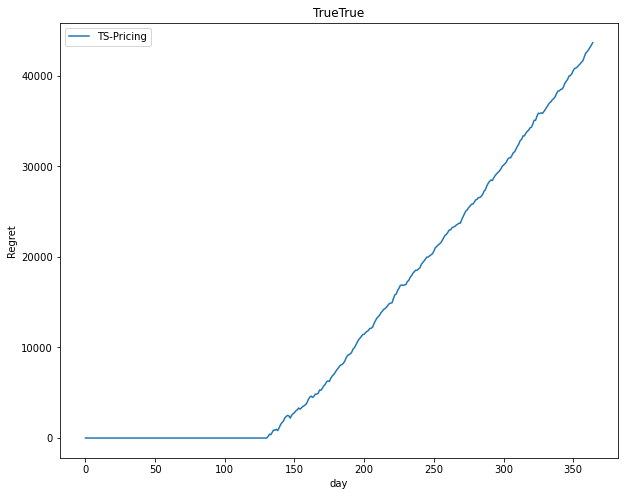

[array([  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.

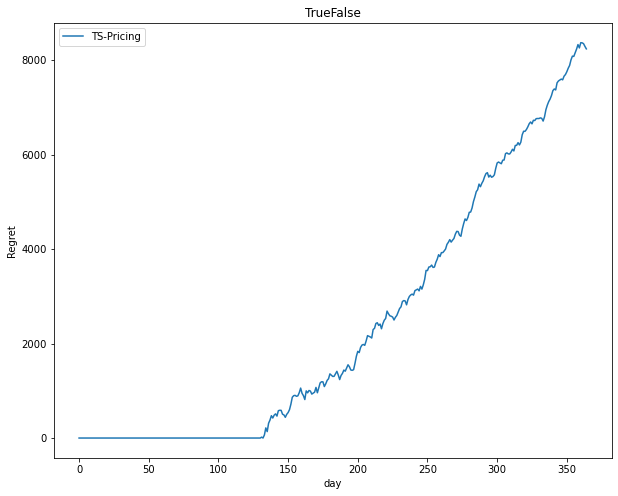

[array([  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.

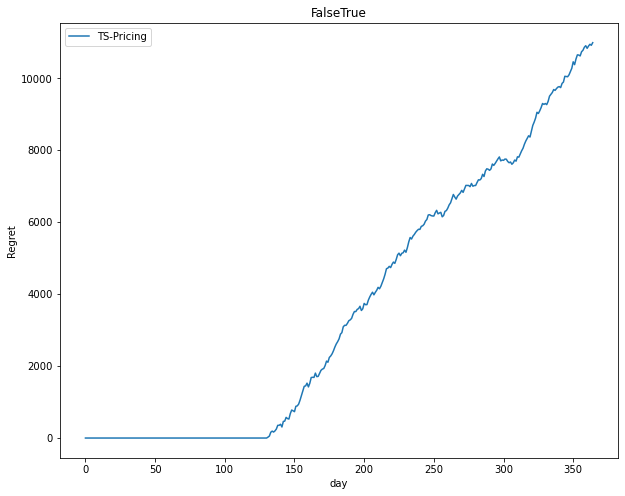

[array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.   

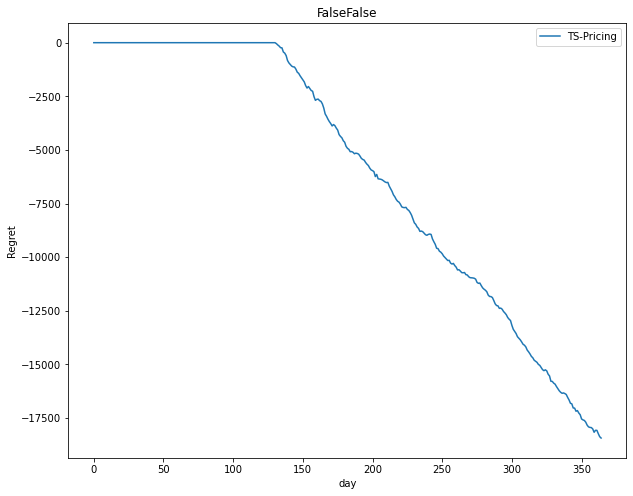

In [11]:


for i in range(4):
    feature_1 = int_to_feature_1[i]
    feature_2 = int_to_feature_2[i]
    val = splitted_rewards_per_experiment[feature_1,feature_2]
    opt = opt_per_experiment[feature_1,feature_2]
    print(opt)
    print(val)
    plt.figure(figsize=(10,8))
    plt.ylabel("Regret")
    plt.xlabel("day")
    plt.title(f"{feature_1}{feature_2}")
    plt.plot(np.cumsum(np.mean(np.array(opt) - np.array(val), axis=0)))

    plt.legend(rewards_per_experiment.keys())
    plt.show()

In [19]:
opt_values


[1026.057162, 60.09728480000001, 179.76419999999996]

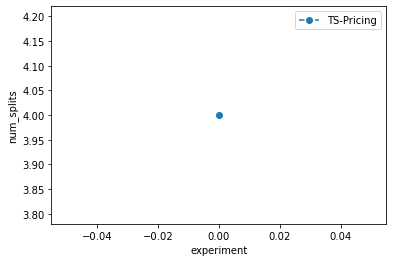

In [14]:
plt.figure()
plt.ylabel("num_splits")
plt.xlabel("experiment")
for val in context_split_per_experiment.values():
    plt.plot(val, '--o')
plt.legend(context_split_per_experiment.keys())
plt.show()

In [15]:
for key in context_split_per_experiment:
    print(f'{key}: avg splits -> {np.mean(context_split_per_experiment[key])}')

TS-Pricing: avg splits -> 4.0


In [16]:
val = days_of_split[ThompsonSampling.LEARNER_NAME]
avg_days = np.mean(val, axis=0)
val, avg_days

([[120, 130, 130]], array([120., 130., 130.]))

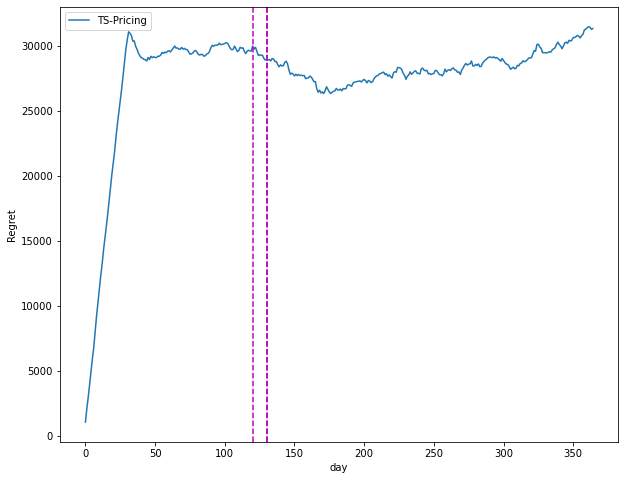

In [17]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(disaggr_opt - val, axis=0)))

#plt.axvline(x=cg_start_from, color='r', linestyle='--')
for val in days_of_split.values():
    avg_days = np.mean(val, axis=0)
    for day in avg_days:
        plt.axvline(x=day, color='m', linestyle='--')

plt.legend(rewards_per_experiment.keys())
plt.show()

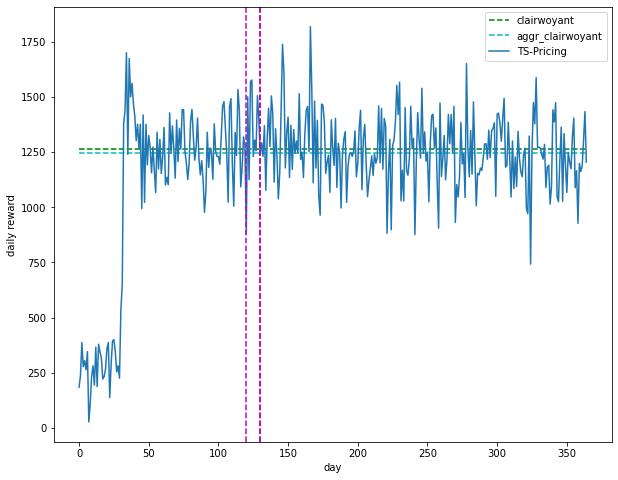

In [18]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([disaggr_opt]*T, '--g', label='clairwoyant')
plt.plot([aggr_opt]*T, '--c', label='aggr_clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)

#plt.axvline(x=cg_start_from, color='r', linestyle='--')
for val in days_of_split.values():
    avg_days = np.mean(val, axis=0)
    for day in avg_days:
        plt.axvline(x=day, color='m', linestyle='--')

plt.legend(loc='best')
plt.show()